In [1]:
import torch 
import random
import os
import json
import nibabel as nib
import matplotlib.pyplot as plt
import numpy as np
from tqdm import tqdm
from dataclasses import dataclass
from PIL import Image
import evaluate
from typing import Any

from transformers import (
    MaskFormerImageProcessor,
    AutoImageProcessor,
    MaskFormerForInstanceSegmentation,
)

import albumentations as A 
from torch.utils.data import DataLoader


In [2]:
random.seed(1)
torch.manual_seed(1)

In [ ]:
data_dir = '../data/Task01_BrainTumour/'

with open(os.path.join(data_dir, 'dataset.json'), 'r') as f:
    dataset = json.load(f)

In [4]:
all_train_files = [
    {"image": os.path.join(data_dir, d["image"]), "label": os.path.join(data_dir, d["label"])}
    for d in dataset['training']]

test_files = [{"image": os.path.join(data_dir, d)} for d in dataset['test']]


# I am going to create a validation set from a subset of train_files
random.shuffle(all_train_files)
n_files_for_validation = int(len(all_train_files) * .05)

val_files = all_train_files[-n_files_for_validation:]
train_files = all_train_files[:-n_files_for_validation]


In [5]:
def load_nii(path): 
    return nib.load(path).get_fdata()
     

def normalize_img(img):
    return (img - np.min(img)) / (np.max(img) - np.min(img) + 1e-6)

In [6]:
def load_flair(sample, slice_idx = None):
    return load_nii(sample["image"])[:, :, slice_idx, 0]

def load_mask_edema(sample, slice_idx = None):
    mask = load_nii(sample["label"])
    mask = mask[:, :, slice_idx]
    mask = np.where(mask >= 1, 1, 0)
    return mask

In [7]:
sample = random.choice(train_files)

In [8]:
load_flair(sample, 75).shape, load_mask_edema(sample, 75).shape, np.unique(load_mask_edema(sample, 75).astype(np.uint8))

((240, 240), (240, 240), array([0, 1], dtype=uint8))

In [9]:
def visualize_sample(sample: dict, slice_idx = 75, axis = None):
    img = load_flair(sample, slice_idx)
    mapping = load_mask_edema(sample, slice_idx)
    mapping = np.where(mapping == 0, np.nan, mapping)

    img = normalize_img(img)
    if axis is None:
        _, ax = plt.subplots(1, 2, figsize=(12, 5)) 
    else: 
        ax = axis
    
    ax[0].imshow(img, cmap='gray')
    ax[0].set_title("MRI Image (FLAIR)")
    ax[0].axis("off")

    ax[1].imshow(img, cmap="gray")
    ax[1].imshow(mapping, cmap="spring", alpha=.4)
    ax[1].set_title("Segmentation Mask Overlay")
    ax[1].axis("off")

    if axis is None:
        plt.show()

    return ax

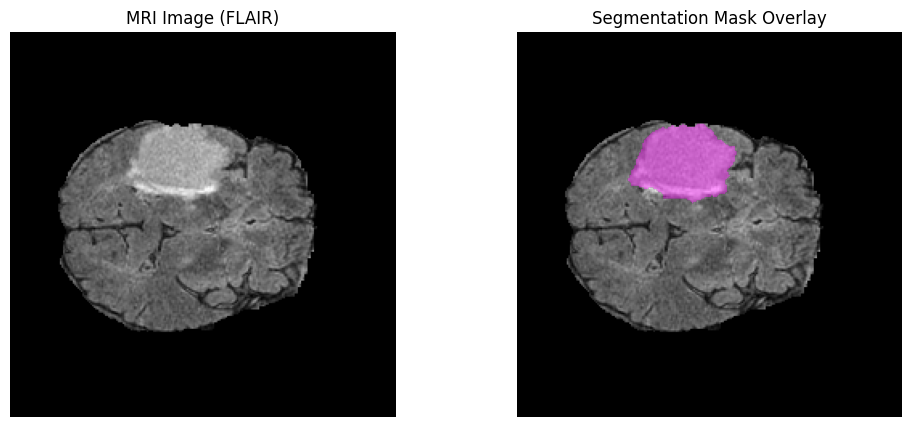

array([<Axes: title={'center': 'MRI Image (FLAIR)'}>,
       <Axes: title={'center': 'Segmentation Mask Overlay'}>],
      dtype=object)

In [10]:
visualize_sample(sample)

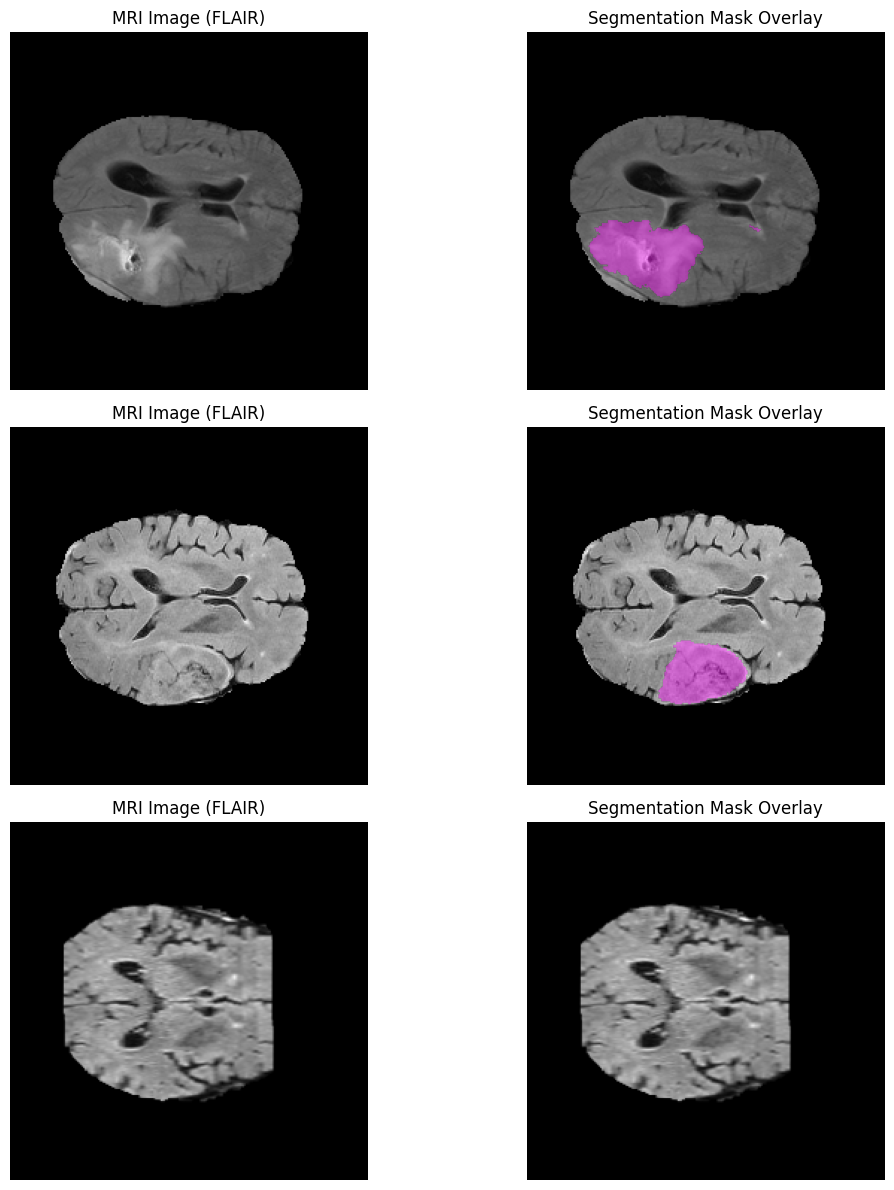

In [11]:
fig, axes = plt.subplots(3, 2, figsize=(12, 12))  # 3 rows, 2 columns (MRI + Overlay)
samples = random.sample(train_files, 3)  # Pick 3 random samples

# Loop through each row and plot using the modified function
for i in range(3):
    visualize_sample(samples[i], 75, axes[i])

plt.tight_layout()
plt.show()


In [12]:
id2label = {int(k): v for k, v in dataset['labels'].items()}
id2label = {0: 'background', 1: 'edema'}
id2label

{0: 'background', 1: 'edema'}

### Preparing the dataset for training

In [13]:

normalize_img(load_flair(sample, 75)).shape

(240, 240)

In [34]:
from torch.utils.data import Dataset

@dataclass
class BRATDataInput:
    original_image: np.ndarray
    transformed_image: np.ndarray
    original_segmentation_map: np.ndarray
    transformed_segmentation_map: np.ndarray


class BRATSDataset(Dataset):
    def __init__(self, data_list, transforms=None, slice_axis=2):
        """
        Args:
            data_list: List of dictionaries with {'image': path, 'label': path}.
            transforms: Albumentations transforms for data augmentation.
            slice_axis: Axis along which to extract 2D slices (0=axial, 1=coronal, 2=sagittal).
        """
        self.data_list = data_list
        self.transforms = transforms
        self.slice_axis = slice_axis
        self.slices_to_retrieve = [38, 77, 115]
    
    def __len__(self):
        return len(self.data_list) * len(self.slices_to_retrieve)

    def __getitem__(self, idx):
        scan_idx = idx // len(self.slices_to_retrieve)
        slice_idx = self.slices_to_retrieve[idx % len(self.slices_to_retrieve)]

        sample = self.data_list[scan_idx]

        image_data = load_flair(sample, slice_idx) # (240, 240)
        image_data = normalize_img(image_data) # (240, 240)
        image_data = np.stack([image_data] * 3, axis=-1) # turns into 3 channels (240, 240, 3)
        image_data = image_data.astype(np.float32)

        label_data = load_mask_edema(sample, slice_idx)
        label_data = label_data.astype(np.uint8)

        

        # transformations 
        if self.transforms:
            augmented = self.transforms(image=image_data, mask=label_data)
            transformed_image = augmented["image"]
            transformed_segmentation_map = augmented["mask"]
        else:
            transformed_image, transformed_segmentation_map = image_data, label_data
        
        return BRATDataInput(
            original_image=image_data,
            original_segmentation_map=label_data,
            transformed_image=transformed_image,
            transformed_segmentation_map=transformed_segmentation_map
        )


preprocessor = MaskFormerImageProcessor(
    ignore_index=0,
    do_reduce_labels=False,
    do_resize=False,
    do_rescale=False,
    do_normalize=False,
)

def collate_fn(batch: BRATDataInput) -> dict:
    original_images = [sample.original_image for sample in batch]
    transformed_images = [sample.transformed_image for sample in batch]
    original_segmentation_maps = [sample.original_segmentation_map for sample in batch]
    transformed_segmentation_maps = [
        sample.transformed_segmentation_map for sample in batch
    ]

    preprocessed_batch = preprocessor(
        transformed_images,
        segmentation_maps=transformed_segmentation_maps,
        return_tensors="pt",
    )

    preprocessed_batch["original_images"] = original_images
    preprocessed_batch["original_segmentation_maps"] = original_segmentation_maps

    return preprocessed_batch


Determines the observed means and std for normalization

In [35]:
relevant_slices = [38, 77, 115]

def compute_mean_std(data_list):
    """Compute mean and std for each MRI modality across the entire dataset."""
    sum_pixels = 0
    sum_sq_pixels = 0
    total_pixels = 0
    
    for sample in data_list:
        image_data = np.stack([load_flair(sample, slice_idx) for slice_idx in relevant_slices], axis=-1)
        for slice_idx in relevant_slices:
            image_data = load_flair(sample, slice_idx) # returns a 240 x 240 matrix

            sum_pixels += image_data.sum()
            sum_sq_pixels += (image_data ** 2).sum()
            total_pixels += image_data.size

    # Compute final mean and std
    mean = sum_pixels / total_pixels
    std = np.sqrt((sum_sq_pixels / total_pixels) - (mean ** 2))  # Variance -> Std

    return mean, std

# Compute on training dataset
#mean_train, std_train = compute_mean_std(train_files)
mean_train = [98.26790214875201] * 3
std_train = [225.43155142558643] * 3

print(f"Computed Mean: {mean_train}, Computed Std: {std_train}")


Computed Mean: [98.26790214875201, 98.26790214875201, 98.26790214875201], Computed Std: [225.43155142558643, 225.43155142558643, 225.43155142558643]


In [36]:
## data augmentation and data loader 
train_transform = A.Compose([
    A.Normalize(mean=mean_train, std=std_train),

    A.VerticalFlip(p=0.5),
    A.RandomRotate90(p=0.5),
    A.RandomBrightnessContrast(brightness_limit=0.1, contrast_limit=0.1, p=0.2),
    A.ElasticTransform(alpha=1, sigma=50, p=0.2),
    A.ToTensorV2()
])

valtest_transform = A.Compose([
    A.Normalize(mean=mean_train, std=std_train),
    A.ToTensorV2()
])

In [102]:
train_dataset = BRATSDataset(train_files, transforms=train_transform)
val_dataset = BRATSDataset(val_files, transforms=valtest_transform)
test_dataset = BRATSDataset(test_files, transforms=valtest_transform)


train_loader = DataLoader(train_dataset, batch_size=8, shuffle=True, num_workers=0, collate_fn=collate_fn)
val_loader = DataLoader(val_dataset, batch_size=8, shuffle=True, num_workers=0, collate_fn=collate_fn)
test_loader = DataLoader(test_dataset, batch_size=8, shuffle=True, num_workers=0, collate_fn=collate_fn)

In [131]:
sample = next(iter(train_loader))

In [132]:
print(
    {
        key: value[0].shape if isinstance(value, list) else value.shape
        for key, value in sample.items()
    }
)

{'pixel_values': torch.Size([8, 3, 240, 240]), 'pixel_mask': torch.Size([8, 240, 240]), 'mask_labels': torch.Size([0, 240, 240]), 'class_labels': torch.Size([0]), 'original_images': (240, 240, 3), 'original_segmentation_maps': (240, 240)}


Create coco annotations

In [122]:
def generate_coco_annotations(train_files, output_file):
    dataset_dicts = []
    n_slices = 155
    image_id = 0

    for sample in train_files:
        for idx in range(n_slices):
            d = {
                "file_name": sample["image"],
                "sem_seg_file_name": sample["label"],
                "image_id": image_id,
                "slice_idx": idx,
                "height": resized_size,
                "width": resized_size
            }

            dataset_dicts.append(d)
            image_id += 1

    with open(output_file, "w") as f:
        json.dump(dataset_dicts, f, indent=4)

#generate_coco_annotations(train_files, "./data/coco_annotations.json")

### Denormalization of the images

In [133]:
def denormalize(image_tensor):
    """Reverses normalization and restores image values correctly."""
    # Move tensor to CPU and convert to NumPy
    image_np = image_tensor.detach().cpu().numpy()
    image_np = image_np[0]  # Convert from (C, H, W) -> (H, W, C)

    # Reverse normalization
    image_np = (image_np * std_train[0]) + mean_train[0]

    # Ensure values are properly scaled
    image_np = (image_np - image_np.min()) / (image_np.max() - image_np.min() + 1e-6)  # Rescale to 0-1

    # Convert to uint8 (0-255)
    image_np = (image_np * 255).astype(np.uint8)

    return image_np


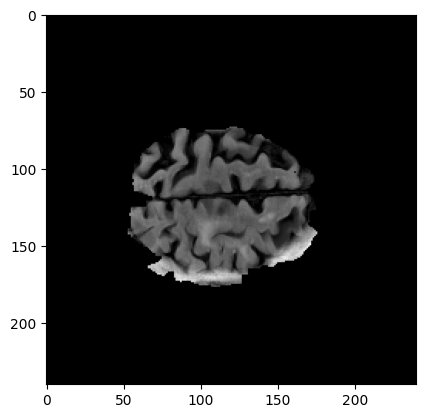

In [134]:
plt.imshow(denormalize(sample['pixel_values'][-1]), cmap='gray')

### Load Model

In [135]:
processor = AutoImageProcessor.from_pretrained("facebook/maskformer-swin-base-coco")
model = MaskFormerForInstanceSegmentation.from_pretrained(
    "facebook/maskformer-swin-base-coco", 
)

/Users/alexis/Projects/202503 Brain Image Segmentation/.environment/lib/python3.10/site-packages/transformers/utils/deprecation.py:172: FutureWarning: `max_size` is deprecated and removed starting from version 4.27.0 for `MaskFormerImageProcessor.__init__`.
  return func(*args, **kwargs)


#### Predicting with model out-of-the-box

In [136]:
image = denormalize(sample['pixel_values'])

inputs = processor(images=image, return_tensors="pt")
with torch.no_grad():
    outputs = model(**inputs)

predicted_semantic_map = processor.post_process_semantic_segmentation(
    outputs
)[0]

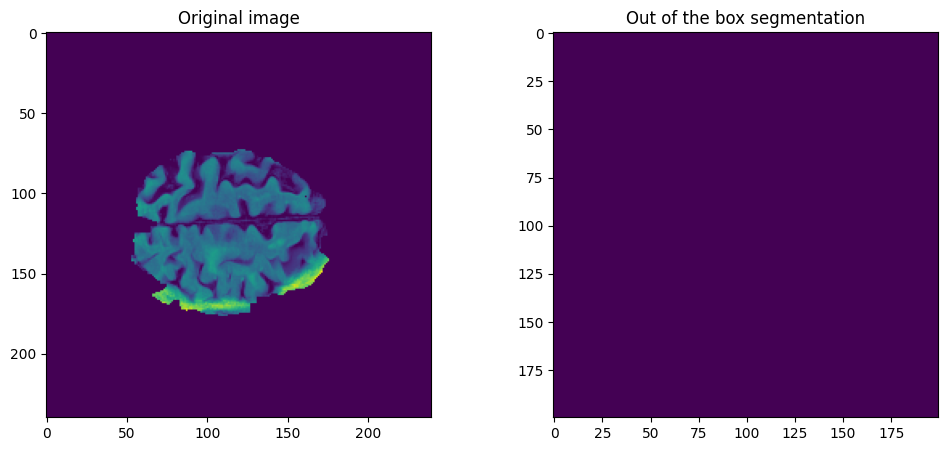

In [137]:
fig, ax = plt.subplots(1, 2, figsize=(12, 5))
ax[0].imshow(denormalize(sample['pixel_values'][-1]))
ax[0].set_title('Original image')

ax[1].imshow(predicted_semantic_map)
ax[1].set_title('Out of the box segmentation')

plt.show()

The identifies de outline of the brain image, but not the tumor

In [47]:
predicted_semantic_map = processor.post_process_panoptic_segmentation(
    outputs
)[0]
predicted_semantic_map

`label_ids_to_fuse` unset. No instance will be fused.


{'segmentation': tensor([[1, 1, 1,  ..., 1, 1, 1],
         [1, 1, 1,  ..., 1, 1, 1],
         [1, 1, 1,  ..., 1, 1, 1],
         ...,
         [1, 1, 1,  ..., 1, 1, 1],
         [1, 1, 1,  ..., 1, 1, 1],
         [1, 1, 1,  ..., 1, 1, 1]], dtype=torch.int32),
 'segments_info': [{'id': 1,
   'label_id': 15,
   'was_fused': False,
   'score': 0.827941}]}

Semantically, no elements were found.

### Training

In [103]:
model = MaskFormerForInstanceSegmentation.from_pretrained(
    "facebook/maskformer-swin-base-ade", id2label=id2label, ignore_mismatched_sizes=True
)

Some weights of MaskFormerForInstanceSegmentation were not initialized from the model checkpoint at facebook/maskformer-swin-base-ade and are newly initialized because the shapes did not match:
- class_predictor.weight: found shape torch.Size([151, 256]) in the checkpoint and torch.Size([3, 256]) in the model instantiated
- class_predictor.bias: found shape torch.Size([151]) in the checkpoint and torch.Size([3]) in the model instantiated
- criterion.empty_weight: found shape torch.Size([151]) in the checkpoint and torch.Size([3]) in the model instantiated
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


In [104]:
# pixel level module contains both the backbone and the pixel decoder
for param in model.model.pixel_level_module.parameters():
    param.requires_grad = False

# Confirm that the parameters are correctly frozen
for name, param in model.model.pixel_level_module.named_parameters():
    assert not param.requires_grad

In [105]:
if torch.cuda.is_available():
    device = "cuda"
elif torch.mps.is_available():
    device = "mps"
else:
    device = "cpu"

print("device:", device)

device: mps


In [106]:
from typing import Any 

metric = evaluate.load("mean_iou")

def evaluate_model(
    model: MaskFormerForInstanceSegmentation,
    dataloder: DataLoader,
    preprocessor: AutoImageProcessor,
    metric: Any,
    id2label: dict, 
    max_batches=None
    ):
    
    model.eval()
    
    with torch.no_grad():
        for idx, batch in enumerate(tqdm(dataloder)):
            if max_batches and idx >= max_batches:
                break
            
            pixel_values = batch["pixel_values"].to(device)
            outputs = model(pixel_values=pixel_values)

            original_images = batch["original_images"]#.to(device)
            target_sizes = [
                (image.shape[0], image.shape[1]) for image in original_images
            ]

            predicted_segmentation_maps = (
                preprocessor.post_process_semantic_segmentation(
                    outputs, target_sizes=target_sizes
                )
            )

            ground_truth_segmentation_maps = batch["original_segmentation_maps"]
            
            metric.add_batch(
                references=ground_truth_segmentation_maps,
                predictions=predicted_segmentation_maps
            )

    
    metric_score = metric.compute(num_labels=len(id2label), ignore_index=None)
    return metric_score


            

In [107]:
#import torch
#import torch.nn.functional as F

def dice_loss(pred, target, smooth=1e-6):
    """
    Computes the Dice Loss between predicted and ground truth masks.
    
    Args:
        pred (torch.Tensor): Predicted logits from the model (before softmax/sigmoid).
        target (torch.Tensor): Ground truth masks (binary: 0 for background, 1 for edema).
        smooth (float): Smoothing factor to avoid division by zero.
        
    Returns:
        torch.Tensor: Dice loss value.
    """
    pred = torch.sigmoid(pred)  # Convert logits to probabilities
    target = target.float()  # Ensure ground truth is float for calculations
    
    intersection = (pred * target).sum()
    union = pred.sum() + target.sum()

    dice = (2.0 * intersection + smooth) / (union + smooth)
    return 1 - dice  # Dice Loss (1 - Dice Score)


In [108]:
def train_model(
    model: MaskFormerForInstanceSegmentation,
    train_dataloader: DataLoader,
    val_dataloader: DataLoader,
    preprocessor: AutoImageProcessor,
    metric: AutoImageProcessor,
    id2label: dict,
    num_epochs=100,
    learning_rate=5e-5,
    log_interval=100
):
    
    model.to(device)
    optimizer = torch.optim.Adam(model.parameters(), lr=learning_rate)

    for epoch in range(num_epochs):
        
        model.train()
        running_loss = 0.0

        for idx, batch in enumerate(tqdm(train_dataloader)):
            optimizer.zero_grad()

            outputs = model(
                pixel_values = batch["pixel_values"].to(device),
                mask_labels = [labels.to(device) for labels in batch["mask_labels"]],
                class_labels = [labels.to(device) for labels in batch["class_labels"]],
            )

            loss = outputs.loss

            loss.backward()
            optimizer.step()

            running_loss += loss.item()
            
                   
            if idx % log_interval == 0 and idx > 0:
                avg_loss = running_loss / (idx + 1)
                print(f"Epoch {epoch + 1},| Iteration {idx} - Loss: {avg_loss:.6f}")
            

        val_mean_iou = evaluate_model(
            model,
            val_dataloader,
            preprocessor,
            metric,
            id2label,
            max_batches=6
        )    
        print(f"Validation Mean IoU: {val_mean_iou}")


In [ ]:
train_model(
    model,
    train_loader,
    val_loader,
    preprocessor,
    metric,
    id2label,
    num_epochs=6
)

In [ ]:
image = denormalize(sample['pixel_values'])

inputs = processor(images=image, return_tensors="pt").to(device)
with torch.no_grad():
    outputs = model(**inputs)

predicted_semantic_map = processor.post_process_semantic_segmentation(
    outputs, ##target_sizes=[image.size]
)[0]

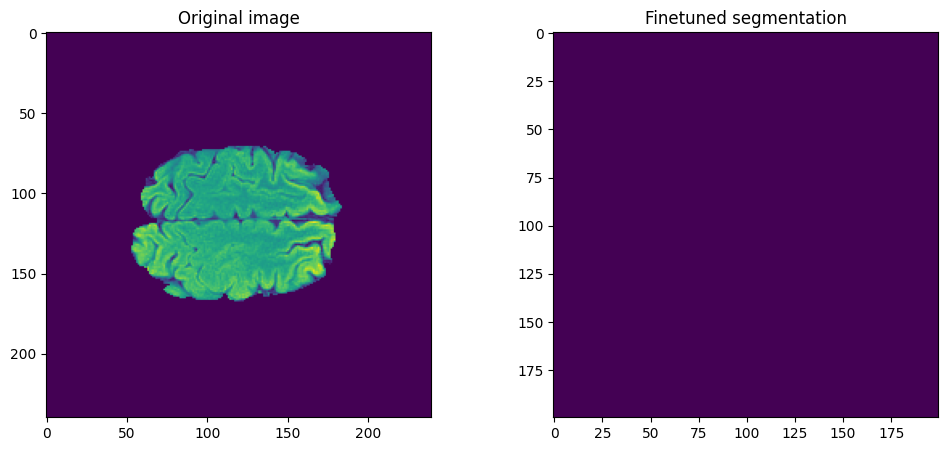

In [ ]:
fig, ax = plt.subplots(1, 2, figsize=(12, 5))
ax[0].imshow(denormalize(sample['pixel_values'][-1]))
ax[0].set_title('Original image')

ax[1].imshow(predicted_semantic_map.cpu().numpy())
ax[1].set_title('Finetuned segmentation')

plt.show()